HW2: Mathew Slade

In [95]:
from numpy import cross, dot
from numpy import array
from math import pi, sqrt, e

In [383]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt # for plotting          
import numpy as np
from copy import copy
from pylab import xlim, ylim
from math import sqrt
from numba import jit

class Particle(object):

    """Class that describes particle"""
    m = 1.0

    def __init__(self,wx0=0,wy0=0,wz0=0,mz0 = 0.0, Bx0 = 0, By0 = 0, Bz0 = 0, x0 = 0.0, y0 = 0.0, z0 = 0.0, vx0 = 0.0, vy0 = 0.0, vz0 = 0.0, Omex0 = 0.0, Omey0 = 0.0, Omez0 = 0.0, tf = 10.0, dt = 0.001):
        self.wx, self.wy, self.wz = wx0, wy0, wz0
        self.Wdrag = np.array([self.wx,self.wy,self.wz])
        self.mz = mz0
        self.Bx = Bx0
        self.By = By0
        self.Bz = Bz0
        self.Barray = [self.Bx,self.By,self.Bz]
        self.B = np.array(self.Barray,float)
        self.x = x0
        self.y = y0
        self.z = z0
        self.parray = [self.x,self.y,self.z]
        self.p = np.array(self.parray, float)
        self.vx = vx0
        self.vy = vy0
        self.vz = vz0
        self.varray = [self.vx,self.vy,self.vz]
        self.v = np.array(self.varray,float)
        self.Omex = Omex0
        self.Omey = Omey0
        self.Omez = Omez0
        self.Omearray = [self.Omex, self.Omey, self.Omez]
        self.Omega = np.array(self.Omearray,float)
        self.t = 0.0
        self.tf = tf
        self.dt = dt

        self.tlabel = 'time (s)'
        self.plabel = 'p (m)'
        self.vlabel = 'v (m/s)'

        npoints = int(tf/dt) # always starting at t = 0.0
        self.npoints = npoints
        self.tarray = np.linspace(0.0, tf,npoints, endpoint = True) # include final timepoint
        self.xv0 = np.array([self.p, self.v]) # NumPy array with initial position and velocity

        print("A new particle has been init'd")

    def F(self, p, v, t):
        # The force on a free particle is 0
        self.farray = np.array([0.0, 0.0, 0.0])
        return np.array(self.farray,float)

    def Euler_step(self): 
        """
        Take a single time step using Euler method
        """
        
        a = self.F(self.p, self.v, self.t) / self.m
        self.p += self.v * self.dt
        self.v += a * self.dt
        self.t += self.dt
        

    def RK4_step(self):
        """
        Take a single time step using RK4 midpoint method
        """
        a1 = self.F(self.p, self.v, self.t) / self.m
        k1 = np.array([self.v, a1])*self.dt

        a2 = self.F(self.p+k1[0]/2, self.v+k1[1]/2, self.t+self.dt/2) / self.m
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dt
        
        a3 = self.F(self.p+k2[0]/2, self.v+k2[1]/2, self.t+self.dt/2) / self.m
        k3 = np.array([self.v+k2[1]/2, a3])*self.dt
        
        a4 = self.F(self.p+k3[0], self.v+k3[1], self.t+self.dt) / self.m
        k4 = np.array([self.v+k3[1], a4])*self.dt

        self.p += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        self.t += self.dt
        
    def work_RK4_step(self):
        a1 = self.F(self.p, self.v, self.t) / self.m
        k1 = np.array([self.v, a1])*self.dt

        a2 = self.F(self.p+k1[0]/2, self.v+k1[1]/2, self.t+self.dt/2) / self.m
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dt
        
        a3 = self.F(self.p+k2[0]/2, self.v+k2[1]/2, self.t+self.dt/2) / self.m
        k3 = np.array([self.v+k2[1]/2, a3])*self.dt
        
        a4 = self.F(self.p+k3[0], self.v+k3[1], self.t+self.dt) / self.m
        k4 = np.array([self.v+k3[1], a4])*self.dt
        
        
        m = 0.62 #The mass of a basketball in kg
        A = 0.045708296 #The cross sectional area of a basketball in m
        crit = 10.0
        spin = sqrt(self.Omex**2 + self.Omey**2 * self.Omez**2)
        s = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        X = (s - crit)/4
        CONSTA = 0.25
        CONSTB = 0.25
        CONSTC = 0.16
        r = sqrt(A/pi)
        Rho0 = 1.225
        if X < 0.0:
            Q = e**(-X**2)
        elif X > 0.0:
            Q = e**((-X**2)/4)
        else:
            Q = 1
        Cd = CONSTA + CONSTB/(1 + e**X) + CONSTC*Q
        cross = np.cross(self.Omega,self.v)
        Fd = np.array([-0.5*Cd*Rho0*A*self.v[0]*s, -0.5*Cd*Rho0*A*self.v[0]*s, -0.5*Cd*Rho0*A*self.v[0]*s])

        self.p += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        self.t += self.dt
        vels = self.v/s
        self.Wdrag += dot(Fd,vels)

    def Euler_trajectory(self):  
        """
        Loop over all time steps to construct a trajectory with Euler method
        Will reinitialize euler trajectory everytime this method is called
        """
        
        px_euler = []
        vx_euler = []
        py_euler = []
        vy_euler = []
        pz_euler = []
        vz_euler = []
        
        while(self.t < self.tf-self.dt/2):
            vx_euler.append(self.v[0])
            px_euler.append(self.p[0])
            vy_euler.append(self.v[1])
            py_euler.append(self.p[1])
            vz_euler.append(self.v[2])
            pz_euler.append(self.p[2])
            self.Euler_step()
        
        self.px_euler = np.array(px_euler)
        self.vx_euler = np.array(vx_euler)
        self.py_euler = np.array(py_euler)
        self.vy_euler = np.array(vy_euler)
        self.pz_euler = np.array(pz_euler)
        self.vz_euler = np.array(vz_euler)

        KE = .5*self.m*(self.vx**2 + self.vy**2 + self.vz**2)
        PE = self.m*9.8*self.p[2]
        print('Final Kinetic Energy:',KE)
        print('Final Potential Energy:',PE)
    @jit
    def RK4_trajectory(self): 
        """
        Loop over all time steps to construct a trajectory with RK4 method
        Will reinitialize euler trajectory everytime this method is called
        """
        
        px_RK4 = []
        vx_RK4 = []
        py_RK4 = []
        vy_RK4 = []
        pz_RK4 = []
        vz_RK4 = []
        
        while(self.t < self.tf - self.dt/2):
            px_RK4.append(self.p[0])
            vx_RK4.append(self.v[0])
            py_RK4.append(self.p[1])
            vy_RK4.append(self.v[1])
            pz_RK4.append(self.p[2])
            vz_RK4.append(self.v[2])
            self.RK4_step()

        self.px_RK4 = np.array(px_RK4)
        self.vx_RK4 = np.array(vx_RK4)
        self.py_RK4 = np.array(py_RK4)
        self.vy_RK4 = np.array(vy_RK4)
        self.pz_RK4 = np.array(pz_RK4)
        self.vz_RK4 = np.array(vz_RK4)
        
        KE = .5*self.m*(self.vx**2 + self.vy**2 + self.vz**2)
        PE = self.m*9.8*self.p[2]
        print('Final Kinetic Energy:',KE)
        print('Final Potential Energy:',PE)

    @jit
    def work_RK4_trajectory(self): 
        """
        Loop over all time steps to construct a trajectory with RK4 method
        Will reinitialize euler trajectory everytime this method is called
        """
        
        px_RK4 = []
        vx_RK4 = []
        py_RK4 = []
        vy_RK4 = []
        pz_RK4 = []
        vz_RK4 = []
        
        while(self.t < self.tf - self.dt/2):
            px_RK4.append(self.p[0])
            vx_RK4.append(self.v[0])
            py_RK4.append(self.p[1])
            vy_RK4.append(self.v[1])
            pz_RK4.append(self.p[2])
            vz_RK4.append(self.v[2])
            self.work_RK4_step()

        self.px_RK4 = np.array(px_RK4)
        self.vx_RK4 = np.array(vx_RK4)
        self.py_RK4 = np.array(py_RK4)
        self.vy_RK4 = np.array(vy_RK4)
        self.pz_RK4 = np.array(pz_RK4)
        self.vz_RK4 = np.array(vz_RK4)
        
        KE = .5*self.m*(self.vx**2 + self.vy**2 + self.vz**2)
        PE = self.m*9.8*self.p[2]
        print('Final Kinetic Energy:',KE)
        print('Final Potential Energy:',PE)
        print('Work Done:',self.Wdrag)
        

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        
        self.xv = odeint(self.derivative, self.xv0, self.tarray)

    def derivative(self, xv, t):
        """right hand side of the differential equation
            Required for odeint """
        
        p =xv[0]
        v =xv[1]
        a = self.F(p, v, t) / self.m
        return np.ravel(np.array([v, a]))

    def results(self):
        """ 
        Print out results in a nice format
        """
        
        print('\n\t Position and Velocity at Final Time:')
        print('Euler:')
        print('t = {} p = {} v = {}'.format(self.t, self.p , self.v))
        
        if hasattr(self, 'xv'):
            print('SciPy ODE Integrator:')
            print('t = {} p = {} v = {}'.format(self.tarray[-1], self.xv[-1, 0], self.xv[-1,1]))
            

    def plot(self):
        """ 
        Make nice plots of our results
        """

        fig1 = plt.figure()
        fig2 = plt.figure()
        fig3 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax2 = fig2.add_subplot(111)
        ax3 = fig3.add_subplot(111)
        
        
        if hasattr(self,'xv'):
            ax1.plot(self.tarray, self.xv[:, 0], "k", label = 'odeint')
        if hasattr(self,'px_euler'):
            ax1.plot(self.tarray, self.px_euler, "b", label = 'euler')
            ax2.plot(self.tarray, self.py_euler, "b", label = 'euler')
            ax3.plot(self.tarray, self.pz_euler, "b", label = 'euler')
        if hasattr(self,'px_RK4'):
            ax1.plot(self.tarray, self.px_RK4, "r", label = 'RK4')
            ax2.plot(self.tarray, self.py_RK4, "r", label = 'RK4')
            ax3.plot(self.tarray, self.pz_RK4, "r", label = 'RK4')
            
        ax1.set_title('X Direction vs Time')
        ax1.set_xlabel("t (s)")
        ax1.set_ylabel("x (m)")
        ax2.set_title('Y Direction vs Time')
        ax2.set_xlabel("t (s)")
        ax2.set_ylabel("y (m)")
        ax3.set_title('Z Direction vs Time')
        ax3.set_xlabel("t (s)")
        ax3.set_ylabel("z (m)")

        ax1.legend()
        ax2.legend()
        ax3.legend()
        
    def trajplotcharged(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
       
        
        if hasattr(self,'xv'):
            ax1.plot(self.tarray, self.xv[:, 0], "k", label = 'odeint')
        if hasattr(self,'px_euler'):
            ax1.plot(self.px_euler, self.py_euler, "r", label = 'Particle Path')
        if hasattr(self,'px_RK4'):
            ax1.plot(self.px_RK4, self.py_RK4, "r", label = 'Particle Path')
        xpoints = []
        ypoints = []
        for x in np.linspace(0.0,0.5,100):
            xpoints.append(x)
            ypoints.append(.25)
        ax1.plot(ypoints,xpoints, "b--", label = 'M. Field End')
        apoints = []
        bpoints = []
        for a in np.linspace(.25-.00025,.25+.00025,10):
            apoints.append(a)
            bpoints.append(.55)
        ax1.plot(bpoints,apoints, "cs", label = 'Detector')
        xlim(0.00,0.55)
        ylim(0.00,0.50)
        ax1.set_title('Particle Trajectory')
        ax1.set_xlabel("x (m)")
        ax1.set_ylabel("y (m)")
        ax1.legend()
        
    def plotdetector(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        
        if hasattr(self,'xv'):
            ax1.plot(self.tarray, self.xv[:, 0], "k", label = 'odeint')
        if hasattr(self,'px_euler'):
            ax1.plot(self.px_euler, self.py_euler, "r", label = 'Particle Path')
        if hasattr(self,'px_RK4'):
            ax1.plot(self.px_RK4, self.py_RK4, "r", label = 'Particle Path')
        apoints = []
        bpoints = []
        for a in np.linspace(.25-.00025,.25+.00025,10):
            apoints.append(a)
            bpoints.append(.55)
        ax1.plot(bpoints,apoints, "c-", label = 'Detector')
        xlim(0.55-.00025,0.55+.00025)
        ylim(.25-.00025-.0002,.25+.00025+.0002)
        ax1.set_title('Particle Trajectory')
        ax1.set_xlabel("x (m)")
        ax1.set_ylabel("y (m)")
        ax1.legend()
        
    def trajplot(self):
        fig1 = plt.figure()
        fig2 = plt.figure()
        fig3 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax2 = fig2.add_subplot(111)
        ax3 = fig3.add_subplot(111)

        
        if hasattr(self,'xv'):
            ax1.plot(self.tarray, self.xv[:, 0], "k", label = 'odeint')
        if hasattr(self,'px_euler'):
            ax1.plot(self.px_euler, self.py_euler, "b", label = 'euler')
            ax2.plot(self.py_euler, self.pz_euler, "b", label = 'euler')
            ax3.plot(self.pz_euler, self.px_euler, "b", label = 'euler')
        if hasattr(self,'px_RK4'):
            ax1.plot(self.px_RK4, self.py_RK4, "r", label = 'RK4')
            ax2.plot(self.py_RK4, self.pz_RK4, "r", label = 'RK4')
            ax3.plot(self.pz_RK4, self.px_RK4, "r", label = 'RK4')
        
        ax1.set_title('XY Trajectory')
        ax2.set_title('YZ Trajectory')
        ax3.set_title('XZ Trajectory')
        ax1.set_xlabel("x (m)")
        ax1.set_ylabel("y (m)")
        ax2.set_xlabel("y (m)")
        ax2.set_ylabel("z (m)")
        ax3.set_xlabel("z (m)")
        ax3.set_ylabel("x (m)")
        
        ax1.legend()
        ax2.legend()
        ax3.legend()
    

In [384]:
#Problem 1
class FallingParticle(Particle):
    g = 9.8

    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt) 
        
    def F(self,p, v, t):
        m = 1.0
        return np.array([0, 0, -self.g*self.m])

A new particle has been init'd
Final Kinetic Energy: 0.0
Final Potential Energy: 381195.5

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999999963 p = [     0.       0.   38897.5] v = [   0.    0. -147.]


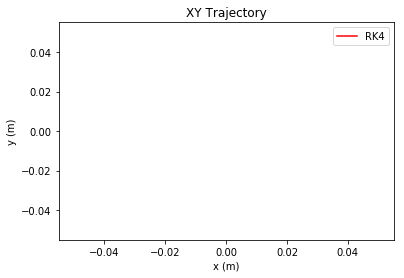

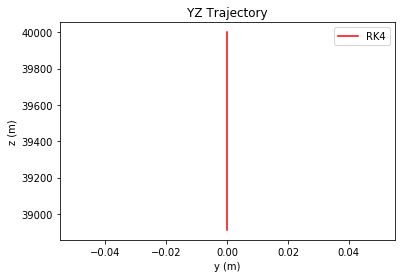

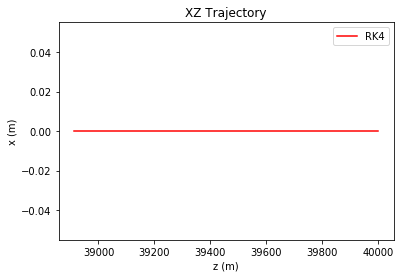

In [385]:
FallingMan = FallingParticle(z0 = 40000.0, tf = 15.0)
FallingMan.RK4_trajectory()
FallingMan.results()
FallingMan.trajplot()

In [87]:
class DragParticleConstant(Particle): #Where a particle falls through an atmosphere of constant air density and simplified gravity
    g = 9.8
    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt)
    def F(self, p, v, t):
        A = 1.0
        M = 5.972*10**24
        Cd = 0.5
        Rho0 = 1.225
        ae = 6.5*(10**-3)
        alpha = 2.5
        T0 = 298
        m = 1.0
        s = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        return np.array([0.0, -0.5*Cd*Rho0*A*self.v[1]*s, -self.g*self.m + 0.5*Cd*Rho0*A*self.v[2]*s])


A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 9.99999999999998 p = [  0.00000000e+00   2.23194202e+00   3.67367721e+04] v = [  0.00000000e+00   1.19429128e-02  -1.47827946e+03]


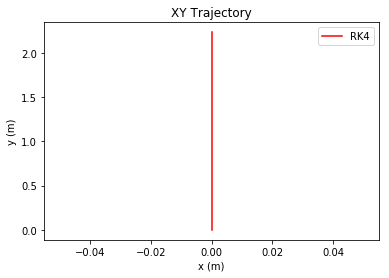

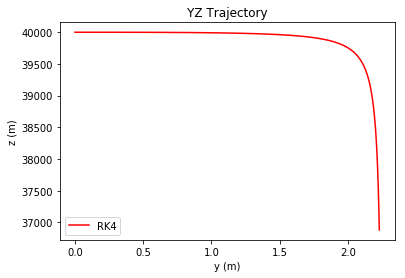

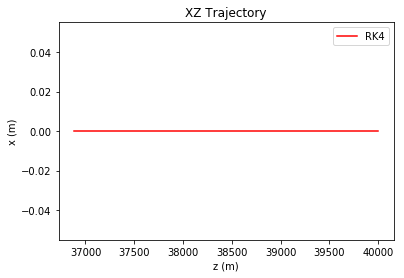

In [398]:
DraggingManC = DragParticleConstant(z0 = 40000, vy0 = 1, vz0 = 1.0, tf = 10.0)
DraggingManC.RK4_trajectory()
DraggingManC.results()
DraggingManC.trajplot()

In [89]:
class DragParticleG(Particle): #Where a particle falls through an atmosphere of variable air density and simplified gravity
    g = 9.8
    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt)
    def F(self, p, v, t):
        A = 1.0
        M = 5.972*10**24
        Cd = 0.5
        Rho0 = 1.0
        ae = 6.5*(10**-3)
        alpha = 2.5
        T0 = 298
        m = 1.0
        s = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        return np.array([0.0, 0.5*Cd*Rho0*((1-(ae*self.z/T0))**alpha)*A*self.v[1]*s, -self.g*self.m + 0.5*Cd*Rho0*((1-(ae*self.z/T0))**alpha)*A*self.v[2]*s])
    

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 9.99999999999998 p = [  0.00000000e+00   1.00729291e+01   3.95076561e+04] v = [  0.           1.01462119 -98.70754068]


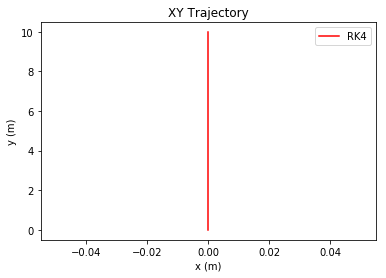

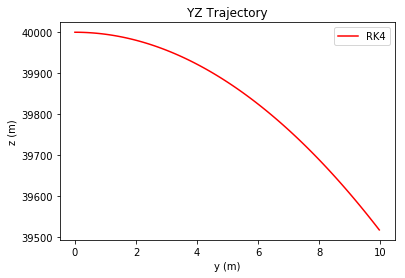

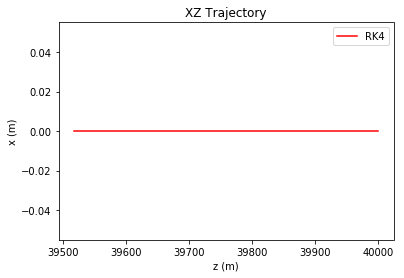

In [90]:
DraggingManG = DragParticleG(z0 = 40000, vy0 = 1, vz0 = 0.0, tf = 10.0)
DraggingManG.RK4_trajectory()
DraggingManG.results()
DraggingManG.trajplot()

In [91]:
class DragParticle(Particle): #Where a particle falls through an atmosphere of constant air density and non-simplified gravity
    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt) 
    def F(self, p, v, t):
        A = 1.0
        M = 5.972*10**24
        Cd = 0.5
        Rho0 = 1.0
        ae = 6.5*(10**-3)
        alpha = 2.5
        T0 = 298
        m = 1.0
        s = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        return np.array([0.0, 0.5*Cd*Rho0*A*self.v[1]*s, -6.67*(10**-11)*M*m/(self.z+(6371*10**3))**2 + 0.5*Cd*Rho0*A*self.v[2]*s])
    

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 9.99999999999998 p = [  0.00000000e+00   4.37955512e+01   7.87060691e+04] v = [   0.           11.81371635 -414.02495072]


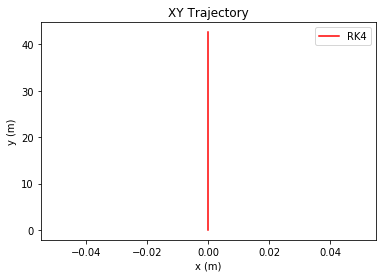

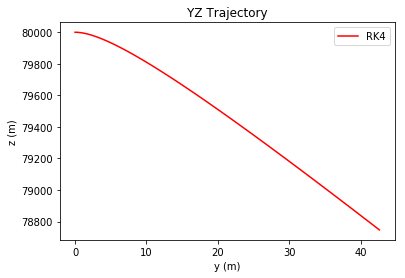

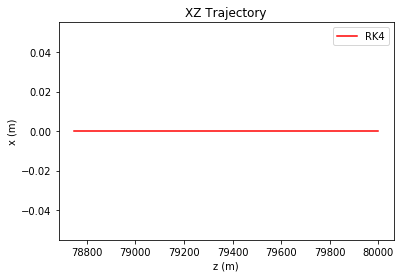

In [92]:
DraggingMan = DragParticle(z0 = 80000, vy0 = 1.0, vz0 = 0.0, tf = 10.0) #The plots no longer change according to my initial conditions.
DraggingMan.RK4_trajectory()
DraggingMan.results()
DraggingMan.trajplot()

In [15]:
#Problem 2

In [377]:
class SpinningBasketball(Particle):
    g = 9.8
    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt)
    def F(self, p, v, t):
        m = 0.62 #The mass of a basketball in kg
        A = 0.045708296 #The cross sectional area of a basketball in m
        crit = 10.0
        spin = sqrt(self.Omex**2 + self.Omey**2 * self.Omez**2)
        s = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        X = (s - crit)/4
        CONSTA = 0.25
        CONSTB = 0.25
        CONSTC = 0.16
        r = sqrt(A/pi)
        Rho0 = 1.225
        if X < 0.0:
            Q = e**(-X**2)
        elif X > 0.0:
            Q = e**((-X**2)/4)
        else:
            Q = 1
        Cd = CONSTA + CONSTB/(1 + e**X) + CONSTC*Q
        cross = np.cross(self.Omega,self.v)
        if spin == 0:
            SPINFORCEX = 0
            SPINFORCEY = 0
            SPINFORCEZ = 0 
        else: 
            SPINFORCEX = 0.25*Rho0*A*r*cross[0]*(s**.4)/(spin**.4 * r**.4)
            SPINFORCEY = 0.25*Rho0*A*r*cross[1]*(s**.4)/(spin**.4 * r**.4)
            SPINFORCEZ = 0.25*Rho0*A*r*cross[2]*(s**.4)/(spin**.4 * r**.4)
        return np.array([-0.5*Cd*Rho0*A*self.v[0]**2 + SPINFORCEX, 
                         -0.5*Cd*Rho0*A*self.v[1]**2 + SPINFORCEY,
                         -self.g*self.m - 0.5*Cd*Rho0*A*self.v[2]**2 + SPINFORCEZ])
    


A new particle has been init'd
Final Kinetic Energy: 12.5
Final Potential Energy: 2804.09877643

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999997126 p = [   0.           99.81227018  286.13252821] v = [ 0.          7.51872075 -3.07232033]


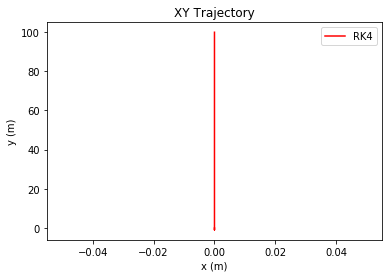

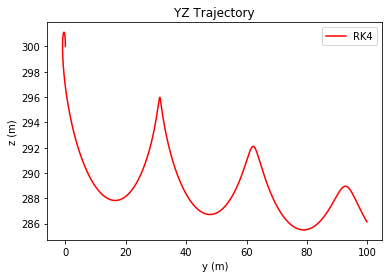

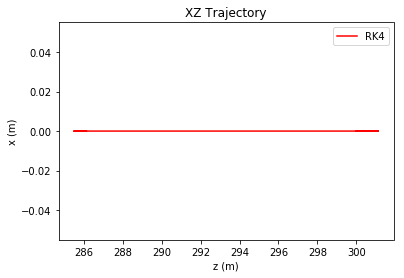

In [391]:
SpinningMan = SpinningBasketball(z0 = 300, vz0 = 5, Omex0 = 2000*pi, tf = 15.0, dt = 0.001)
SpinningMan.RK4_trajectory()
SpinningMan.results()
SpinningMan.trajplot()

A new particle has been init'd


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars


Final Kinetic Energy: 12.5
Final Potential Energy: 0

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999997126 p = [  0.   0. -inf] v = [  0.   0. -inf]


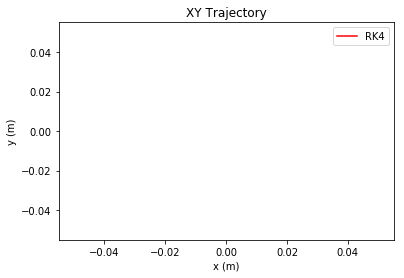

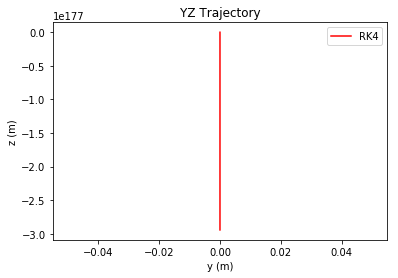

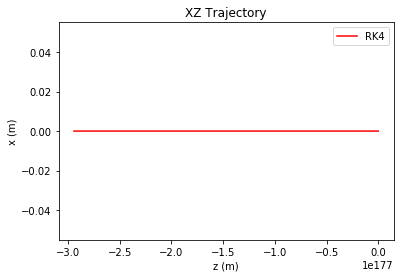

In [397]:
SpinningSideMan = SpinningBasketball(z0 = 300, vz0 = 5, Omez0 = 2000*pi, tf = 15.0, dt = 0.001)
SpinningSideMan.RK4_trajectory()
SpinningSideMan.results()
SpinningSideMan.trajplot()

In [381]:
class ChargedParticle(Particle):
    def __init__(self,wx0=0,wy0=0,wz0=0,mz0=0,Bx0=0,By0=0,Bz0=0,x0=0,y0=0,z0=0,vx0=0,vy0=0,vz0=0,Omex0=0,Omey0=0,Omez0=0,tf=10,dt=0.1):
        super().__init__(wz0,wy0,wz0,mz0,Bx0,By0,Bz0,x0,y0,z0,vx0,vy0,vz0,Omex0,Omey0,Omez0,tf,dt)
    def F(self, p, v, t):
        cross = np.cross(self.v,self.B)
        el = 1.602 * 10**-19
        m = 1.0
        while self.p[0] <= .25:
            return np.array([el*m*cross[0]/self.mz,el*m*cross[1]/self.mz, el*m*cross[2]/self.mz])
        while self.p[0] > .25:
            self.forcearray = np.array([0.0, 0.0, 0.0])
            return np.array(self.forcearray,float)

Some assumptions: the particle enters the field at point 0 (at the midpoint of the x side of the field). If the particle leaves the particle having changed its course exactly by 90 degrees, it will leave approximately at the point (0.25, 0.25).

A new particle has been init'd
Final Kinetic Energy: 0.08000000000000002
Final Potential Energy: 0

	 Position and Velocity at Final Time:
Euler:
t = 2.9999999999997806 p = [ 1.05847963  0.25017202  0.        ] v = [  4.00502846e-01  -2.63829755e-06   0.00000000e+00]


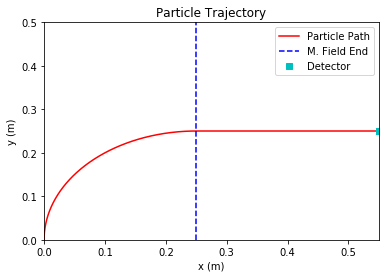

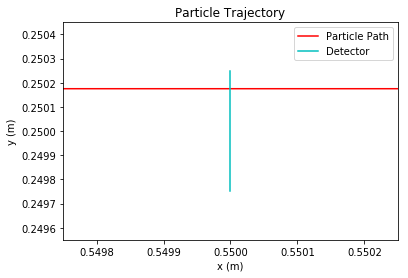

In [382]:
ChargedMan = ChargedParticle(Bz0 = .9985*10**20, mz0 = 10, vy0 = .4, tf = 3.0, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999997126 p = [ 5.86467969  0.24914022  0.        ] v = [  4.00503438e-01  -5.43505592e-05   0.00000000e+00]


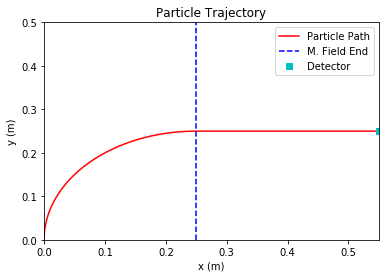

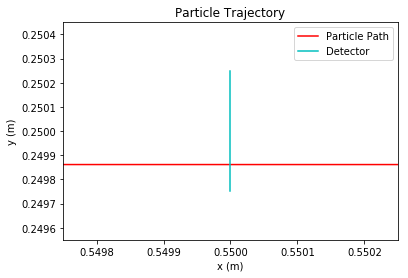

In [259]:
ChargedMan = ChargedParticle(Bz0 = 4.998*10**20, mz0 = 50, vy0 = .4, tf = 15.0, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999997126 p = [ 5.86467969  0.24914022  0.        ] v = [  4.00503438e-01  -5.43505592e-05   0.00000000e+00]


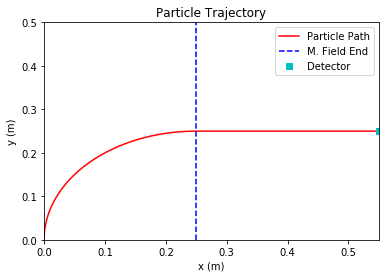

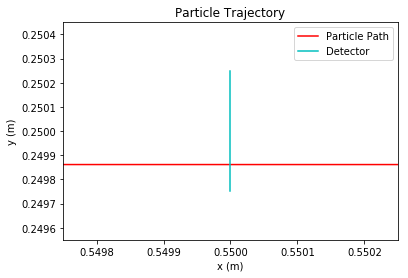

In [261]:
ChargedMan = ChargedParticle(Bz0 = 9.996*10**20, mz0 = 100, vy0 = .4, tf = 15.0, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 14.999999999997126 p = [ 5.86467969  0.24914022  0.        ] v = [  4.00503438e-01  -5.43505592e-05   0.00000000e+00]


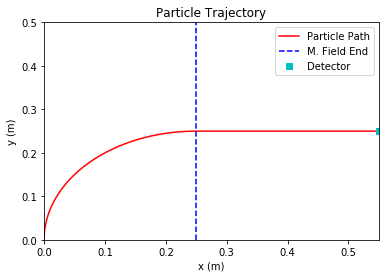

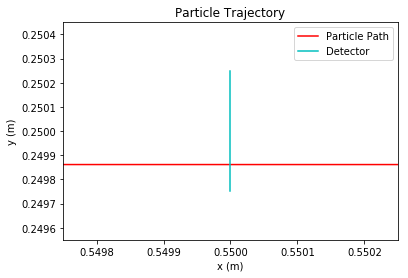

In [263]:
ChargedMan = ChargedParticle(Bz0 = 9.996*10**21, mz0 = 1000, vy0 = .4, tf = 15.0, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 1.73199999999992 p = [ 0.55067711  0.24999929  0.        ] v = [  4.00503061e-01  -1.56075324e-04   0.00000000e+00]


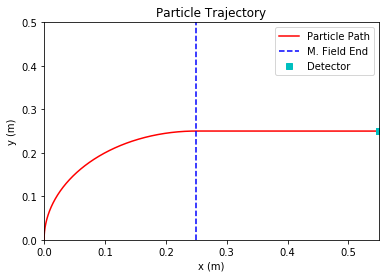

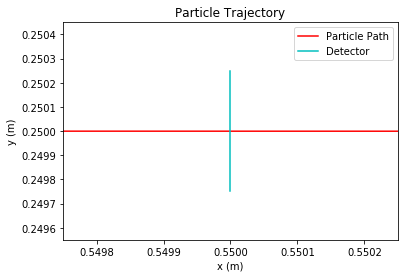

In [319]:
ChargedMan = ChargedParticle(Bz0 = 4.24466*10**20, mz0 = 42.5, vy0 = .4, tf = 1.7315, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 1.73199999999992 p = [ 0.55852225  0.21553549  0.        ] v = [ 0.39976399 -0.02517394  0.        ]


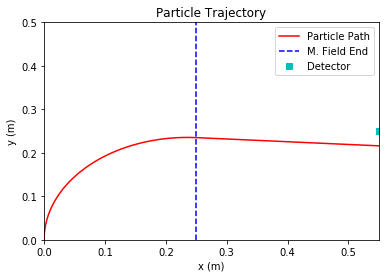

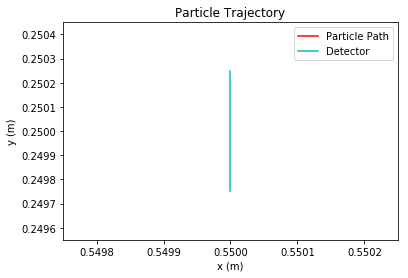

In [320]:
ChargedMan = ChargedParticle(Bz0 = 4.24466*10**20, mz0 = 40, vy0 = .4, tf = 1.7315, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()

A new particle has been init'd

	 Position and Velocity at Final Time:
Euler:
t = 1.7519999999999178 p = [ 0.54978294  0.28095726  0.        ] v = [ 0.39984913  0.02208017  0.        ]


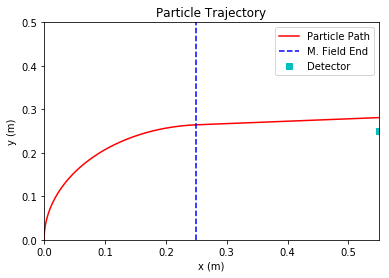

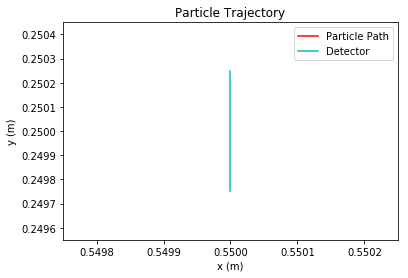

In [323]:
ChargedMan = ChargedParticle(Bz0 = 4.24466*10**20, mz0 = 45, vy0 = .4, tf = 1.7515, dt = 0.001)
ChargedMan.RK4_trajectory()
ChargedMan.results()
ChargedMan.trajplotcharged()
ChargedMan.plotdetector()